# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [389]:
!pip install pmdarima 

In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from fbprophet import Prophet as proph

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [391]:
df = pd.read_csv('data/new_zillow_data.csv')

In [392]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,193814.0,...,1036773.0,1039292.0,1051475.0,1052389.0,1062227.0,1073321.0,1088262.0,1101458.0,1110816.0,1117997.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,...,497434.0,499976.0,502451.0,504692.0,507078.0,508667.0,510851.0,513170.0,516360.0,519384.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,261664.0,...,1105905.0,1101323.0,1092186.0,1083389.0,1083178.0,1081122.0,1084203.0,1086301.0,1088716.0,1088755.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,...,345982.0,349035.0,353498.0,358004.0,363402.0,369313.0,376254.0,383839.0,392947.0,403712.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,...,635561.0,638519.0,641360.0,643819.0,646973.0,649403.0,652545.0,654806.0,658509.0,661889.0


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30839 entries, 0 to 30838
Columns: 316 entries, RegionID to 2021-07-31
dtypes: float64(307), int64(3), object(6)
memory usage: 74.3+ MB


In [394]:
df[df.RegionName == 21532]

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
7439,66899,7510,21532,Zip,MD,MD,Frostburg,Cumberland,Allegany County,61791.0,...,105512.0,106089.0,107488.0,108782.0,110307.0,112570.0,114839.0,117788.0,119612.0,122002.0


# Step 2: Data Preprocessing

In [395]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [396]:
#datetimes = get_datetimes(df)

In [397]:
#datetimes

In [398]:
#date_dict = {}
#for key, value in list(zip(df.columns[7:], datetimes)):
#    date_dict[key] = value

In [399]:
#df.rename(columns=date_dict)

# Step 3: EDA and Visualization

In [400]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}
#
#matplotlib.rc('font', **font)
#
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [401]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,193814.0,...,1036773.0,1039292.0,1051475.0,1052389.0,1062227.0,1073321.0,1088262.0,1101458.0,1110816.0,1117997.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,...,497434.0,499976.0,502451.0,504692.0,507078.0,508667.0,510851.0,513170.0,516360.0,519384.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,261664.0,...,1105905.0,1101323.0,1092186.0,1083389.0,1083178.0,1081122.0,1084203.0,1086301.0,1088716.0,1088755.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,...,345982.0,349035.0,353498.0,358004.0,363402.0,369313.0,376254.0,383839.0,392947.0,403712.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,...,635561.0,638519.0,641360.0,643819.0,646973.0,649403.0,652545.0,654806.0,658509.0,661889.0


## Absolute Price Gain in 22, 10, and 5 Years

In [402]:
df['total_increase'] = df['2021-07-31'] - df['2001-07-31']
df['ten_year_increase'] = df['2021-07-31'] - df['2011-07-31']
df['five_year_increase'] = df['2021-07-31'] - df['2016-07-31']

In [403]:
df[['total_increase', 'ten_year_increase', 'five_year_increase']].isna().sum()

total_increase        11913
ten_year_increase      2393
five_year_increase      563
dtype: int64

In [404]:
total_increase_top_ten = df.sort_values('total_increase', ascending=False)[:10]
ten_year_increase_top_ten = df.sort_values('ten_year_increase', ascending=False)[:10]
five_year_increase_top_ten = df.sort_values('five_year_increase', ascending=False)[:10]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


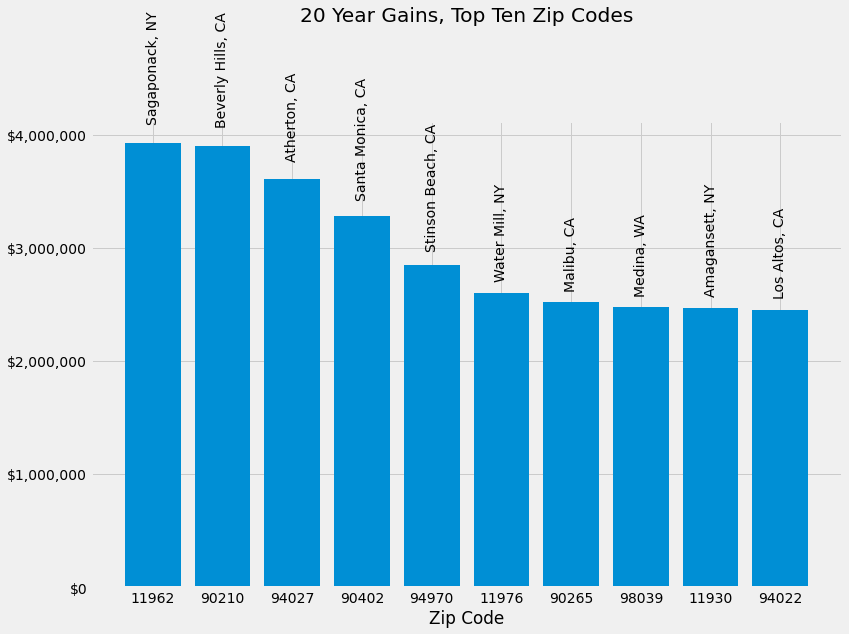

In [405]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(total_increase_top_ten.RegionName.astype('str'), total_increase_top_ten.total_increase)
ax.set_title('20 Year Gains, Top Ten Zip Codes', y=1.2)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 4000000, 5))
ax.set_yticklabels(['$0', '$1,000,000','$2,000,000','$3,000,000','$4,000,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            total_increase_top_ten.City.values[i] + ', ' + total_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


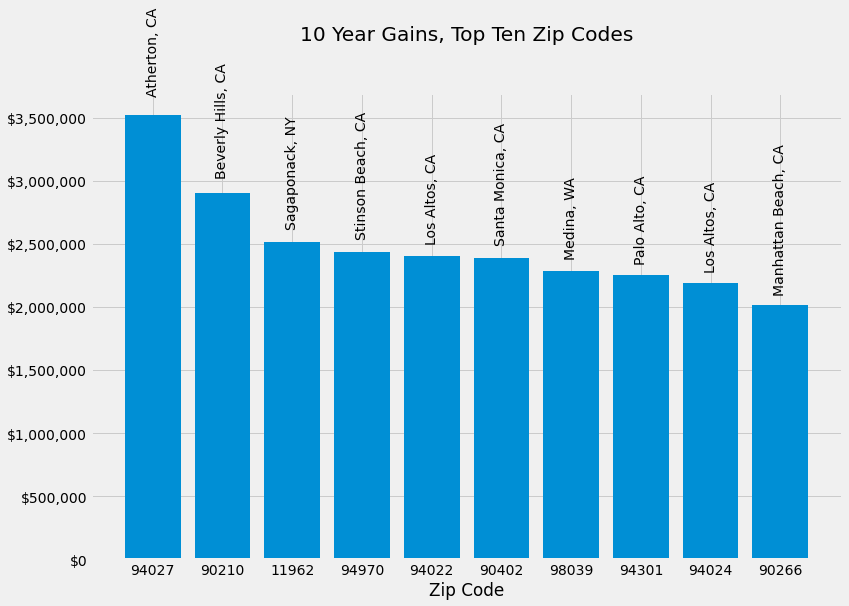

In [406]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(ten_year_increase_top_ten.RegionName.astype('str'), ten_year_increase_top_ten.ten_year_increase)
ax.set_title('10 Year Gains, Top Ten Zip Codes', y=1.1)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 3500000, 8))
ax.set_yticklabels(['$0','$500,000','$1,000,000','$1,500,000','$2,000,000','$2,500,000','$3,000,000',
                   '$3,500,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            ten_year_increase_top_ten.City.values[i] + ', ' + ten_year_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

In [407]:
five_year_increase_top_ten.State.values[0]

'CA'

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


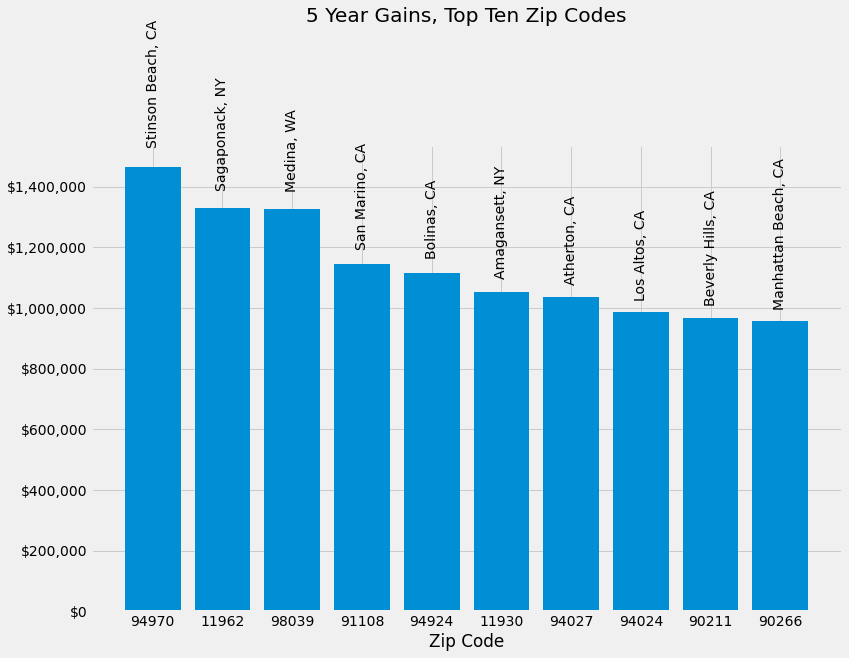

In [408]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(five_year_increase_top_ten.RegionName.astype('str'), five_year_increase_top_ten.five_year_increase)
ax.set_title('5 Year Gains, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 1400000, 8))
ax.set_yticklabels(['$0','$200,000','$400,000','$600,000',
                   '$800,000','$1,000,000','$1,200,000','$1,400,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            five_year_increase_top_ten.City.values[i] + ', ' + five_year_increase_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## Return on Investment (ROI) in 22, 10, and 5 Years for Homes of Any Price

In [409]:
df['total_roi'] = (df['2021-07-31'] - df['2001-07-31']) / df['2001-07-31'] * 100
df['ten_year_roi'] = (df['2021-07-31'] - df['2011-07-31']) / df['2011-07-31'] * 100
df['five_year_roi'] = (df['2021-07-31'] - df['2016-07-31']) / df['2016-07-31'] * 100

In [410]:
over_million = df[df['2021-07-31'] > 1000000]

In [411]:
million_total_roi_top_ten = over_million.sort_values('total_roi', ascending=False)[:10]
million_ten_year_roi_top_ten = over_million.sort_values('ten_year_roi', ascending=False)[:10]
million_five_year_roi_top_ten = over_million.sort_values('five_year_roi', ascending=False)[:10]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


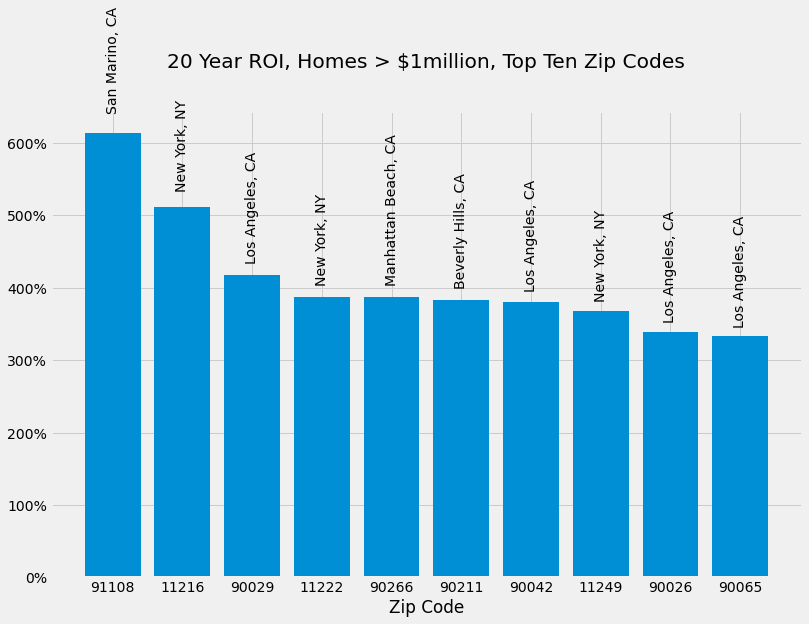

In [412]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_total_roi_top_ten.RegionName.astype('str'), million_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.08)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 600, 7))
ax.set_yticklabels(['0%', '100%', '200%', '300%', '400%', '500%', '600%'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_total_roi_top_ten.City.values[i] + ', ' + million_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


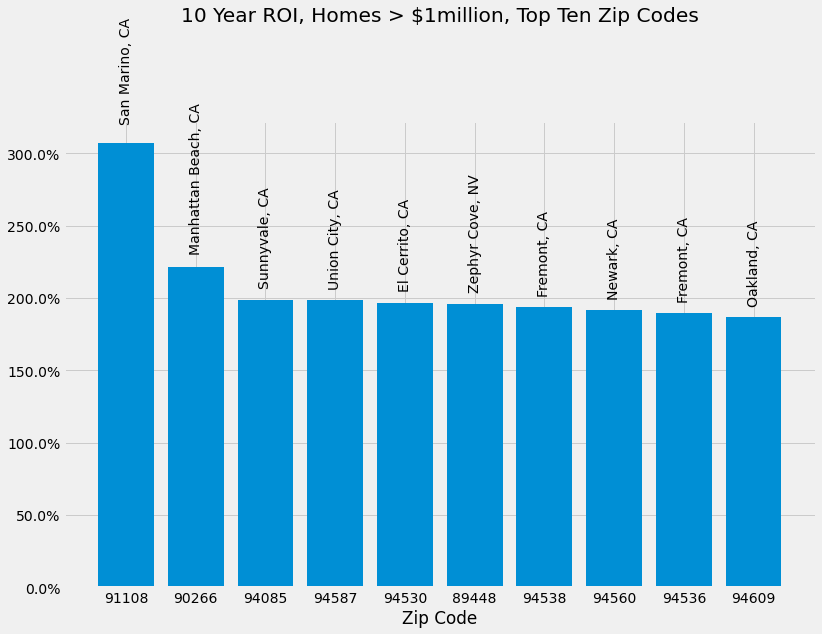

In [413]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_ten_year_roi_top_ten.RegionName.astype('str'), million_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.20)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0,300,7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_ten_year_roi_top_ten.City.values[i] + ', ' + million_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


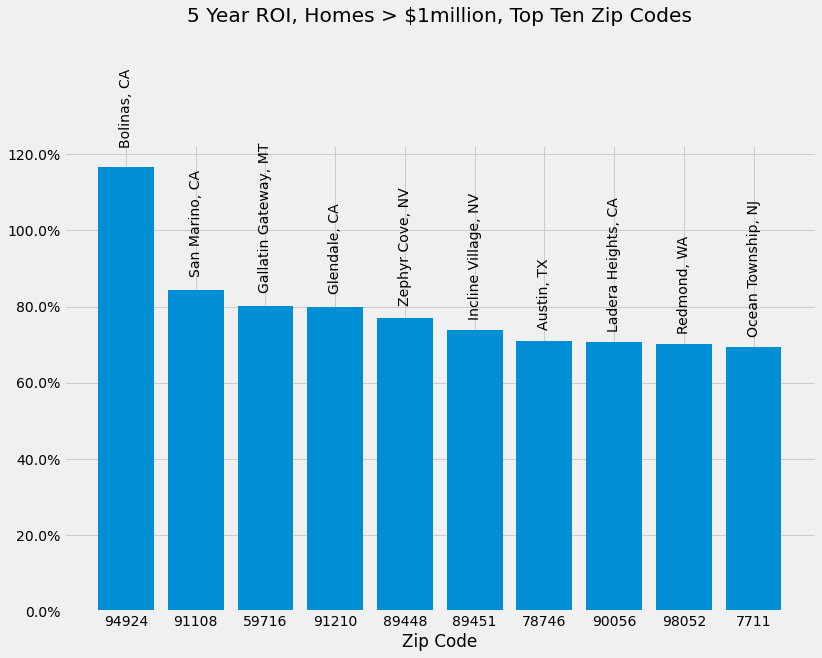

In [414]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(million_five_year_roi_top_ten.RegionName.astype('str'), million_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 120, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 120, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            million_five_year_roi_top_ten.City.values[i] + ', ' + million_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes > 500k and < 1million

In [415]:
affordable = df[(df['2021-07-31'] < 1000000) & (df['2021-07-31'] > 500000)]

In [416]:
affordable_total_roi_top_ten = affordable.sort_values('total_roi', ascending=False)[:10]
affordable_ten_year_roi_top_ten = affordable.sort_values('ten_year_roi', ascending=False)[:10]
affordable_five_year_roi_top_ten = affordable.sort_values('five_year_roi', ascending=False)[:10]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


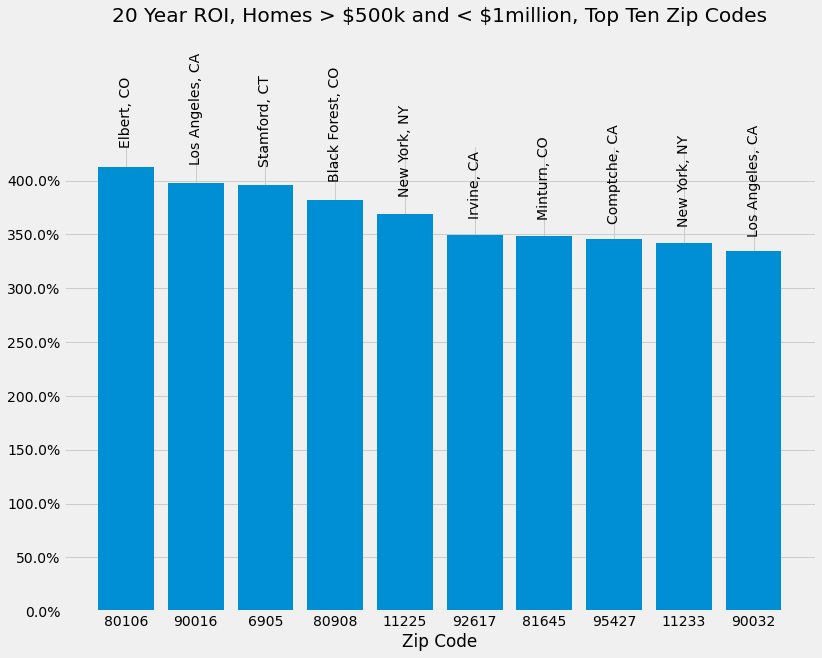

In [417]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_total_roi_top_ten.RegionName.astype('str'), affordable_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 400, 9))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 400, 9)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_total_roi_top_ten.City.values[i] + ', ' + affordable_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


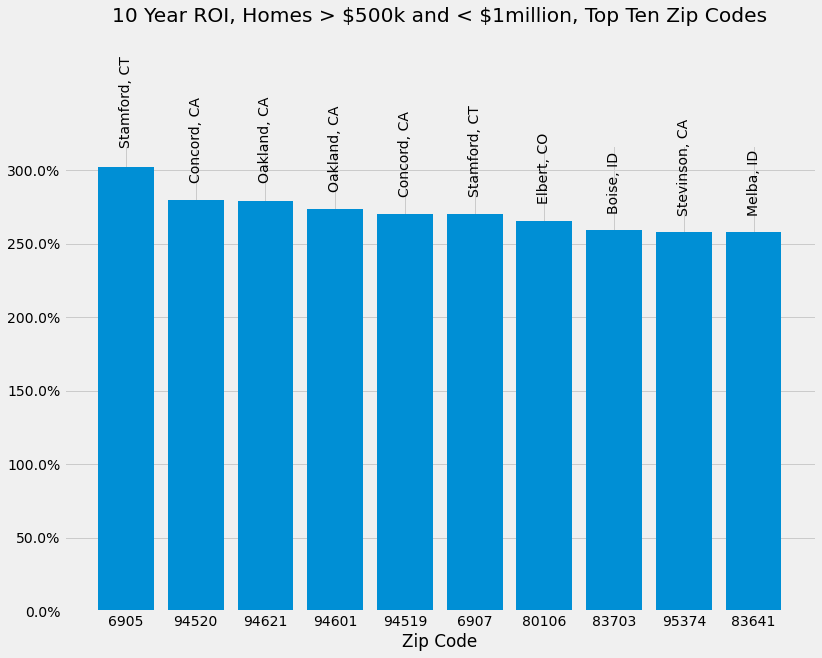

In [418]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_ten_year_roi_top_ten.RegionName.astype('str'), affordable_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 300, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_ten_year_roi_top_ten.City.values[i] + ', ' + affordable_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


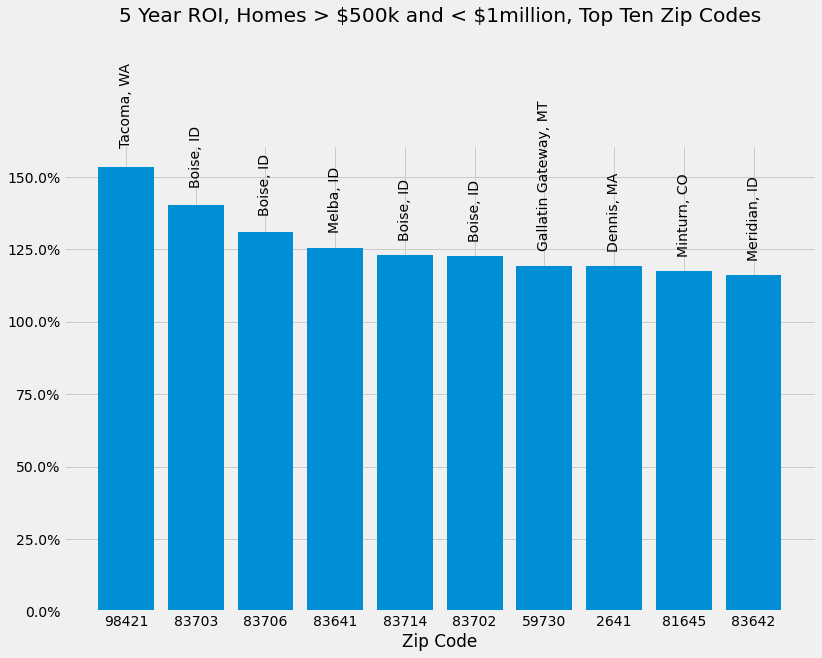

In [419]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(affordable_five_year_roi_top_ten.RegionName.astype('str'), affordable_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$500k and < \$1million, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 150, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 150, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            affordable_five_year_roi_top_ten.City.values[i] + ', ' + affordable_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes > 250k and < 500k

In [420]:
less_500k = df[(df['2021-07-31'] < 500000) & (df['2021-07-31'] > 250000)]

In [421]:
less_500k_total_roi_top_ten = less_500k.sort_values('total_roi', ascending=False)[:10]
less_500k_ten_year_roi_top_ten = less_500k.sort_values('ten_year_roi', ascending=False)[:10]
less_500k_five_year_roi_top_ten = less_500k.sort_values('five_year_roi', ascending=False)[:10]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


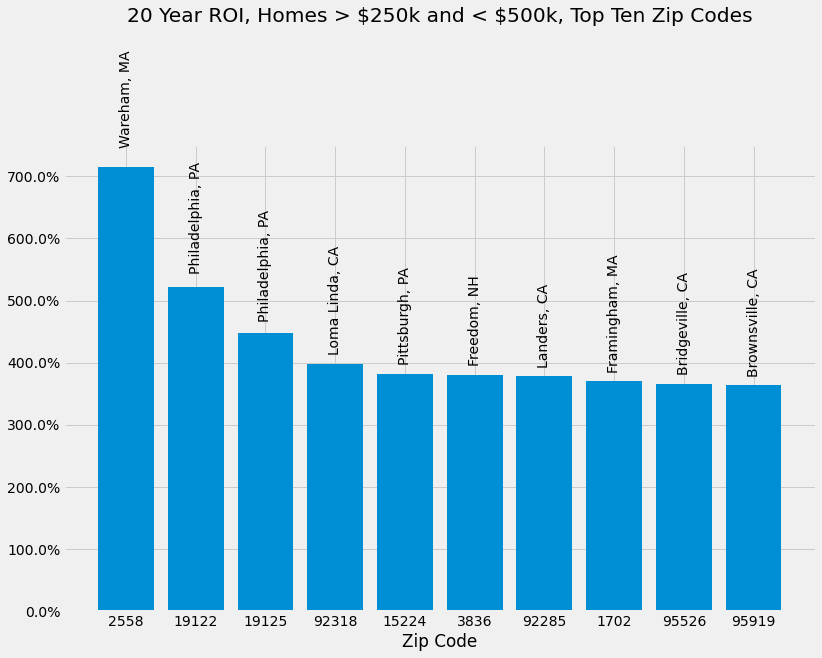

In [422]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_total_roi_top_ten.RegionName.astype('str'), less_500k_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 700, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 700, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_total_roi_top_ten.City.values[i] + ', ' + less_500k_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


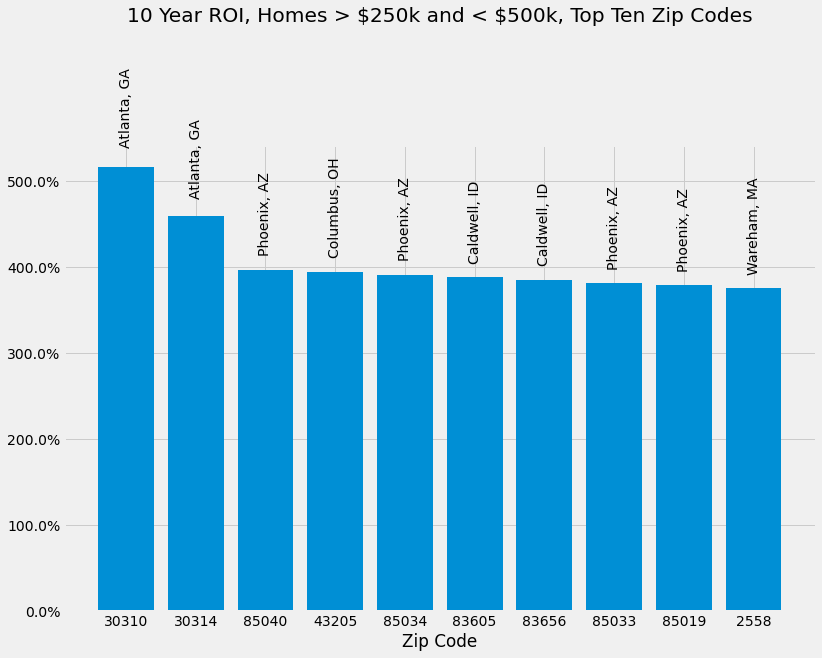

In [423]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_ten_year_roi_top_ten.RegionName.astype('str'), less_500k_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 500, 6)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_ten_year_roi_top_ten.City.values[i] + ', ' + less_500k_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


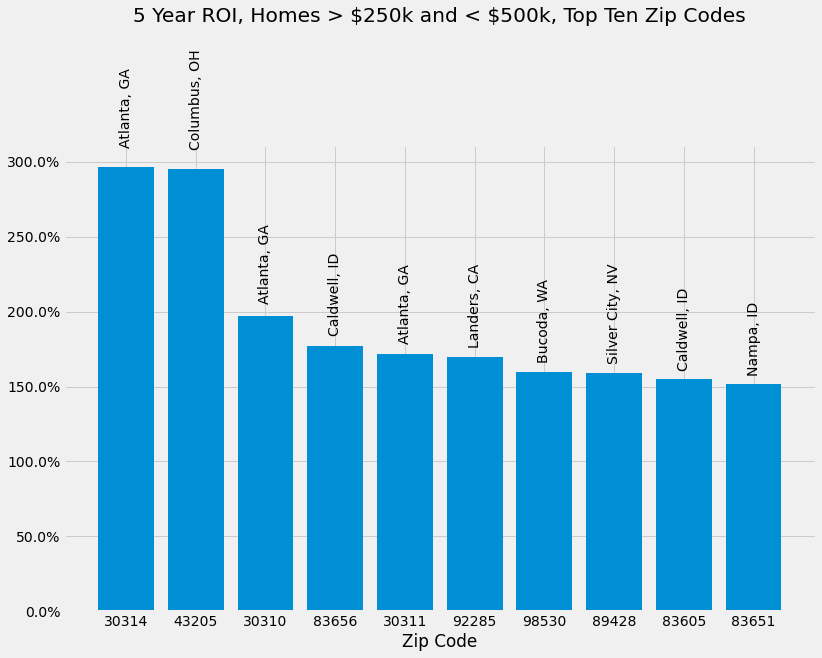

In [424]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_500k_five_year_roi_top_ten.RegionName.astype('str'), less_500k_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes > \$250k and < \$500k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 300, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 300, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_500k_five_year_roi_top_ten.City.values[i] + ', ' + less_500k_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

## ROI in 22, 10, and 5 Years for Homes < 250k

In [425]:
less_250k = df[df['2021-07-31'] < 250000]

In [426]:
less_250k_total_roi_top_ten = less_250k.sort_values('total_roi', ascending=False)[:10]
less_250k_ten_year_roi_top_ten = less_250k.sort_values('ten_year_roi', ascending=False)[:10]
less_250k_five_year_roi_top_ten = less_250k.sort_values('five_year_roi', ascending=False)[:10]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


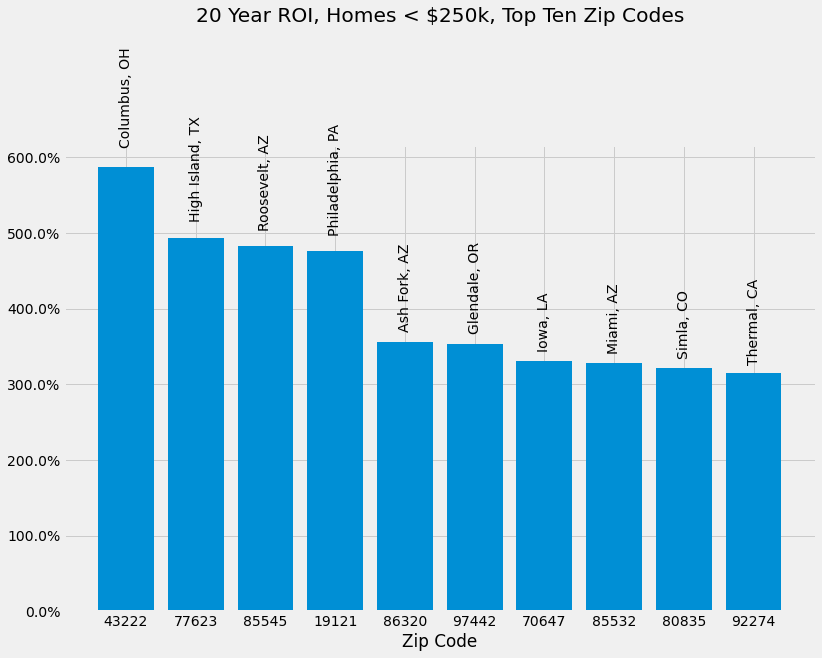

In [427]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_total_roi_top_ten.RegionName.astype('str'), less_250k_total_roi_top_ten.total_roi)
ax.set_title('20 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 600, 7))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 600, 7)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_total_roi_top_ten.City.values[i] + ', ' + less_250k_total_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


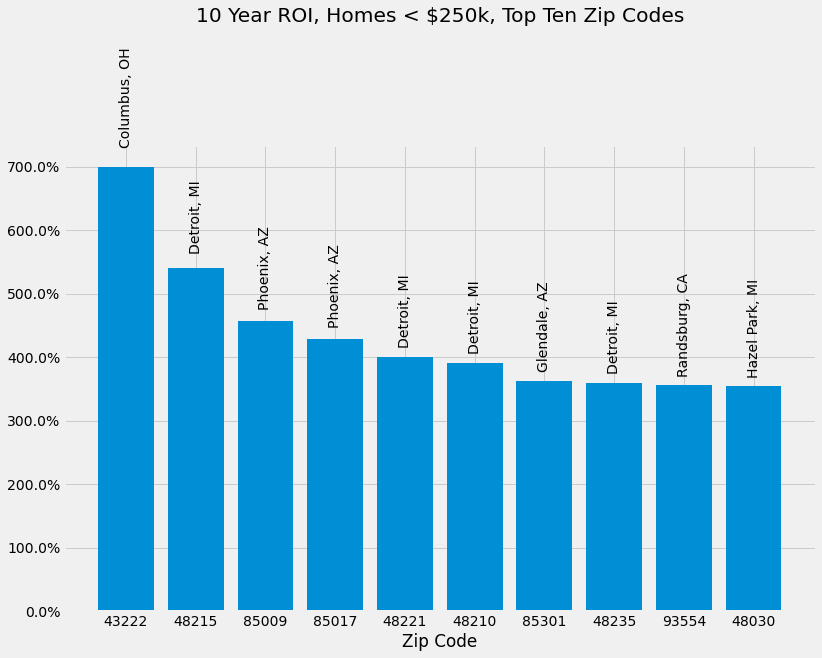

In [428]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_ten_year_roi_top_ten.RegionName.astype('str'), less_250k_ten_year_roi_top_ten.ten_year_roi)
ax.set_title('10 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.25)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 700, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 700, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_ten_year_roi_top_ten.City.values[i] + ', ' + less_250k_ten_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

In [453]:
less_250k_five_year_roi_top_ten

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-04-30,2021-05-31,2021-06-30,2021-07-31,total_increase,ten_year_increase,five_year_increase,total_roi,ten_year_roi,five_year_roi
14627,76590,14840,43222,Zip,OH,OH,Columbus,Columbus,Franklin County,26584.0,...,154981.0,160457.0,166551.0,174458.0,149074.0,152640.0,135258.0,587.275449,699.605830,345.045918
20926,72851,21725,33840,Zip,FL,FL,Lakeland,Lakeland-Winter Haven,Polk County,25754.0,...,141911.0,146273.0,151676.0,157125.0,119086.0,121444.0,111321.0,313.062909,340.360416,243.037726
8169,71900,8249,32254,Zip,FL,FL,Jacksonville,Jacksonville,Duval County,42007.0,...,104920.0,107131.0,110549.0,114813.0,53210.0,79648.0,78949.0,86.375664,226.497938,220.134397
10112,77516,10222,45225,Zip,OH,OH,Cincinnati,Cincinnati,Hamilton County,32152.0,...,67990.0,71651.0,75321.0,79109.0,30978.0,58388.0,53925.0,64.361846,281.781767,214.124047
9568,76572,9668,43203,Zip,OH,OH,Columbus,Columbus,Franklin County,81131.0,...,216455.0,222226.0,227381.0,231893.0,130044.0,178270.0,157314.0,127.683139,332.450628,210.936054
5671,76579,5721,43211,Zip,OH,OH,Columbus,Columbus,Franklin County,50423.0,...,99605.0,102770.0,106504.0,109996.0,40048.0,71712.0,74066.0,57.253960,187.315850,206.139716
2137,65799,2149,19132,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,17489.0,...,69927.0,71945.0,73117.0,74536.0,51091.0,42521.0,50166.0,217.918533,132.815868,205.851457
5228,79059,5275,48204,Zip,MI,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,5866.0,...,32605.0,33926.0,35268.0,36442.0,23804.0,25640.0,24395.0,188.352587,237.363451,202.498547
2961,71862,2982,32208,Zip,FL,FL,Jacksonville,Jacksonville,Duval County,49595.0,...,126820.0,129303.0,132501.0,136236.0,71801.0,98859.0,90901.0,111.431675,264.491532,200.509540
6164,79057,6217,48202,Zip,MI,MI,Detroit,Detroit-Warren-Dearborn,Wayne County,37885.0,...,193456.0,199161.0,201778.0,201025.0,125028.0,156705.0,131703.0,164.517020,353.576264,189.987306


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


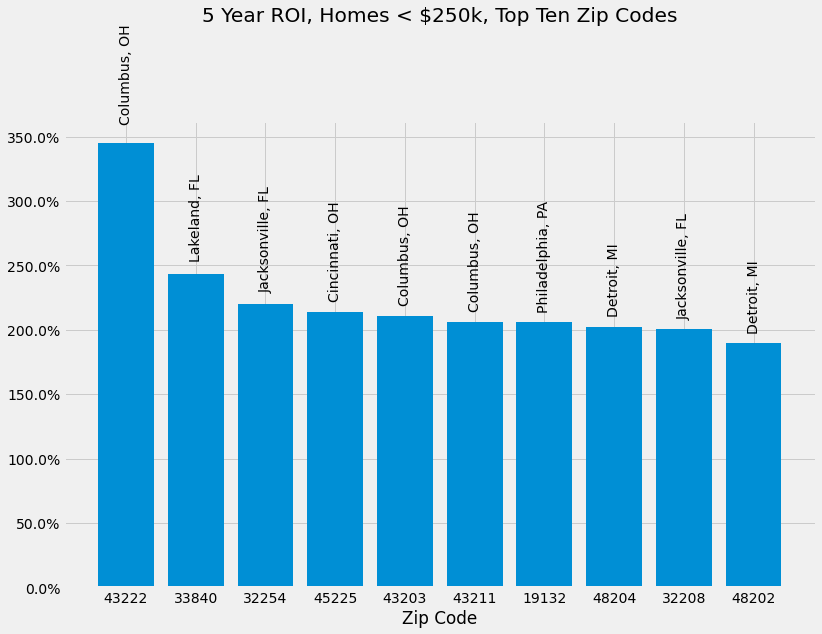

In [429]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(less_250k_five_year_roi_top_ten.RegionName.astype('str'), less_250k_five_year_roi_top_ten.five_year_roi)
ax.set_title('5 Year ROI, Homes < $250k, Top Ten Zip Codes', y=1.2)
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 350, 8))
ax.set_yticklabels([str(x) + '%' for x in np.linspace(0, 350, 8)])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            less_250k_five_year_roi_top_ten.City.values[i] + ', ' + less_250k_five_year_roi_top_ten.State.values[i], 
            ha='center', rotation='vertical');

In [430]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-04-30,2021-05-31,2021-06-30,2021-07-31,total_increase,ten_year_increase,five_year_increase,total_roi,ten_year_roi,five_year_roi
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,193814.0,...,1088262.0,1101458.0,1110816.0,1117997.0,681967.0,404945.0,114080.0,156.403688,56.790388,11.363489
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,...,510851.0,513170.0,516360.0,519384.0,144513.0,120242.0,44920.0,38.550061,30.125118,9.467525
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,261664.0,...,1084203.0,1086301.0,1088716.0,1088755.0,614689.0,352369.0,57060.0,129.663169,47.851127,5.530704
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,...,376254.0,383839.0,392947.0,403712.0,174389.0,142521.0,68210.0,76.045142,54.565816,20.330728
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,...,652545.0,654806.0,658509.0,661889.0,181427.0,158396.0,44955.0,37.760947,31.459424,7.286841


# Step 4: Reshape from Wide to Long Format

In [431]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [432]:
cols_to_drop = ['total_increase', 'ten_year_increase', 'five_year_increase',
               'total_roi', 'ten_year_roi', 'five_year_roi']
df.drop(cols_to_drop, axis=1, inplace=True)

In [433]:
melted = melt_data(df)

In [434]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,time,value
0,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,1996-01-31,193814.0
1,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,1996-01-31,262402.0
2,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,1996-01-31,261664.0
3,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,Zip,TX,1996-01-31,201649.0
4,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,1996-01-31,353678.0


In [435]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7650220 entries, 0 to 9467572
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   RegionType  object        
 8   StateName   object        
 9   time        datetime64[ns]
 10  value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 700.4+ MB


In [436]:
melted['time'] = pd.to_datetime(melted['time'])

In [437]:
melted.set_index('time', inplace=True)

In [438]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-01-31,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,193814.0
1996-01-31,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,262402.0
1996-01-31,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,Zip,NY,261664.0
1996-01-31,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,Zip,TX,201649.0
1996-01-31,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,Zip,IL,353678.0


# Best Zip Code Time Series

In [439]:
def DickeyFullerTest(ts):
    
    '''
    Takes in a time series and returns the results of the Dickey Fuller Test in a Panda Series format.
    '''

    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value

    return dfoutput

In [440]:
def decompose(ts):
    '''
    Takes in a time series and returns four plots: the orignal, trend, seasonal, and residuals.
    '''

    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(15,8))
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left');

In [441]:
frostburg = melted[melted.RegionName == 21532]

In [442]:
frostburg

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
1996-01-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61791.0
1996-02-29,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61614.0
1996-03-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61487.0
1996-04-30,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61259.0
1996-05-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,61070.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,112570.0
2021-04-30,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,114839.0
2021-05-31,21532,66899,7510,Frostburg,MD,Cumberland,Allegany County,Zip,MD,117788.0


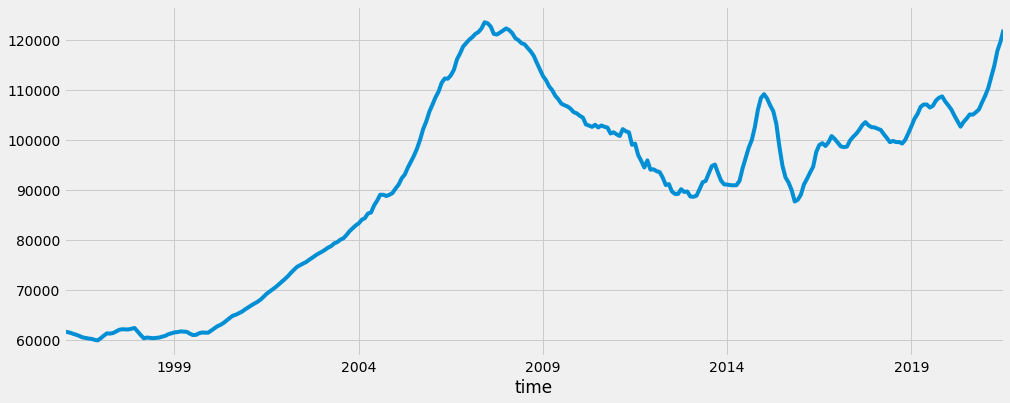

In [443]:
frostburg.value.plot(figsize=(15,6));

## 43222 Columbus, OH:  Best ROI less thatn 250k 

In [444]:
less_250k_best_zip = less_250k.sort_values('five_year_roi', ascending=False)[:1]['RegionName'].values

In [446]:
less_250k_best_zip

array([43222])

In [447]:
int(less_250k_best_zip)

43222

In [454]:
columbus_43222 = melted[melted.RegionName == int(less_250k_best_zip)]

In [455]:
columbus_43222 = columbus_43222.resample('MS').mean()

In [456]:
columbus_43222

,RegionName,RegionID,SizeRank,value
time,,,,
1996-01-01,43222,76590,14840,26584.0
1996-02-01,43222,76590,14840,25884.0
1996-03-01,43222,76590,14840,25538.0
1996-04-01,43222,76590,14840,24695.0
1996-05-01,43222,76590,14840,24074.0
...,...,...,...,...
2021-03-01,43222,76590,14840,150342.0
2021-04-01,43222,76590,14840,154981.0
2021-05-01,43222,76590,14840,160457.0


In [457]:
columbus_43222 = columbus_43222.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

In [458]:
columbus_43222

,value
time,
1996-01-01,26584.0
1996-02-01,25884.0
1996-03-01,25538.0
1996-04-01,24695.0
1996-05-01,24074.0
...,...
2021-03-01,150342.0
2021-04-01,154981.0
2021-05-01,160457.0


### Check rolling mean and std. deviation

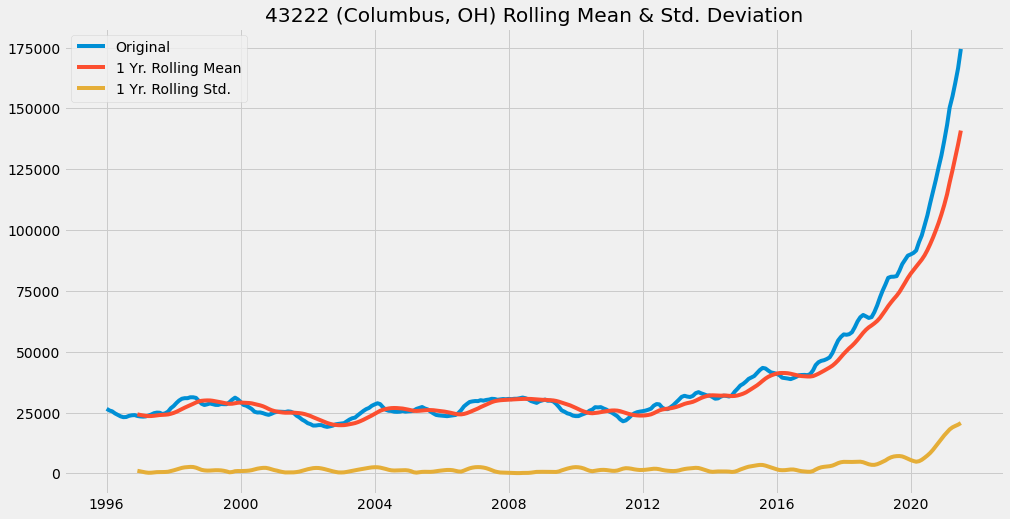

In [460]:
roll_mean_43222 = columbus_43222.rolling(window=12).mean()
roll_std_43222 = columbus_43222.rolling(window=12).std()

fig = plt.figure(figsize=(15,8))
plt.plot(columbus_43222, label='Original')
plt.plot(roll_mean_43222, label='1 Yr. Rolling Mean')
plt.plot(roll_std_43222, label=('1 Yr. Rolling Std.'))
plt.legend(loc='best')
plt.title('43222 (Columbus, OH) Rolling Mean & Std. Deviation');

### Check seasonal decomposition

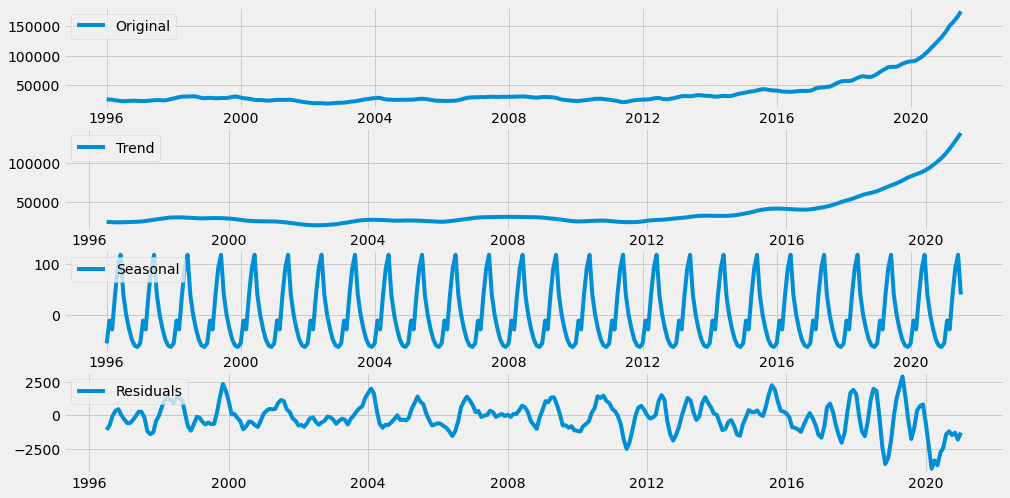

In [461]:
decompose(columbus_43222)

### Check Dickey Fuller test

In [462]:
DickeyFullerTest(columbus_43222)

Test Statistic                   3.005380
p-value                          1.000000
# Lags Used                     16.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64

Clearly there is an upward trend. The Dickey Fuller Test p-value of .973 confirms this.

### Try first order differencing

In [463]:
columbus_43222_diff = columbus_43222.diff()
columbus_43222_diff.dropna(inplace=True)

In [464]:
columbus_43222_diff

,value
time,
1996-02-01,-700.0
1996-03-01,-346.0
1996-04-01,-843.0
1996-05-01,-621.0
1996-06-01,-594.0
...,...
2021-03-01,7091.0
2021-04-01,4639.0
2021-05-01,5476.0


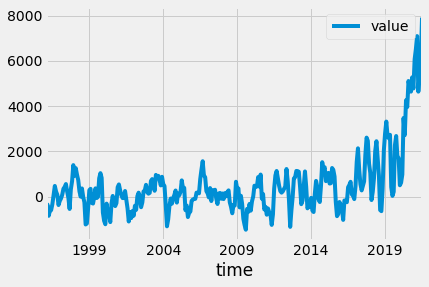

In [465]:
columbus_43222_diff.plot();

In [466]:
DickeyFullerTest(columbus_43222_diff)

Test Statistic                   3.762039
p-value                          1.000000
# Lags Used                     16.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

The p_value is just over the theshold of .05.  Let's try second order differencing.

### Try second order differencing.  

In [468]:
columbus_43222_diff2 = columbus_43222_diff.diff()
columbus_43222_diff2.dropna(inplace=True)

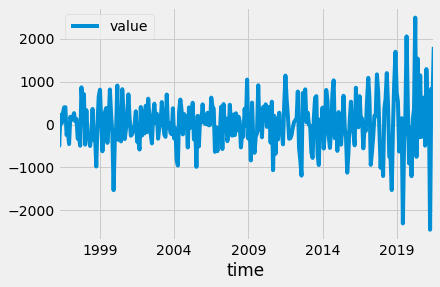

In [469]:
columbus_43222_diff2.plot();

In [72]:
DickeyFullerTest(denver_80216_diff2)

Test Statistic                -7.069573e+00
p-value                        4.977585e-10
# Lags Used                    1.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64

The p-value is now well below the threshold.

### Try PACF and ACF 

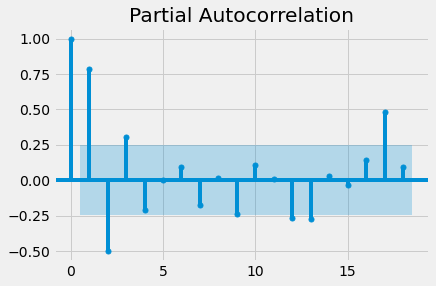

In [73]:
plot_pacf(denver_80216_diff);

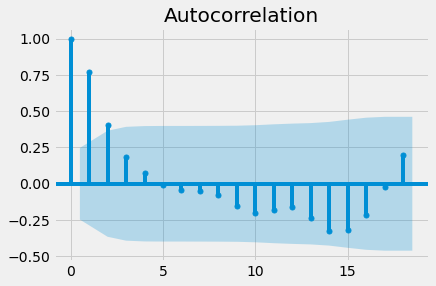

In [74]:
plot_acf(denver_80216_diff);

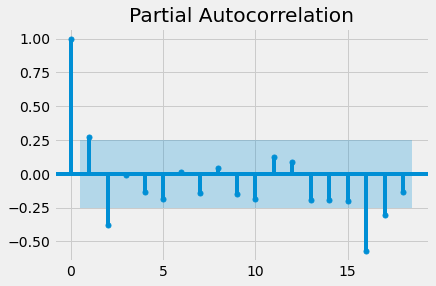

In [75]:
plot_pacf(denver_80216_diff2);

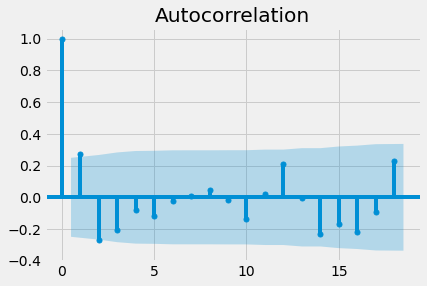

In [76]:
plot_acf(denver_80216_diff2);

### Train Test Split

In [77]:
cutoff = round(denver_80216.shape[0]*.8)
train = denver_80216[:cutoff]
test = denver_80216[cutoff:]

### Baseline Model

In [78]:
naive = train.shift(periods=1)

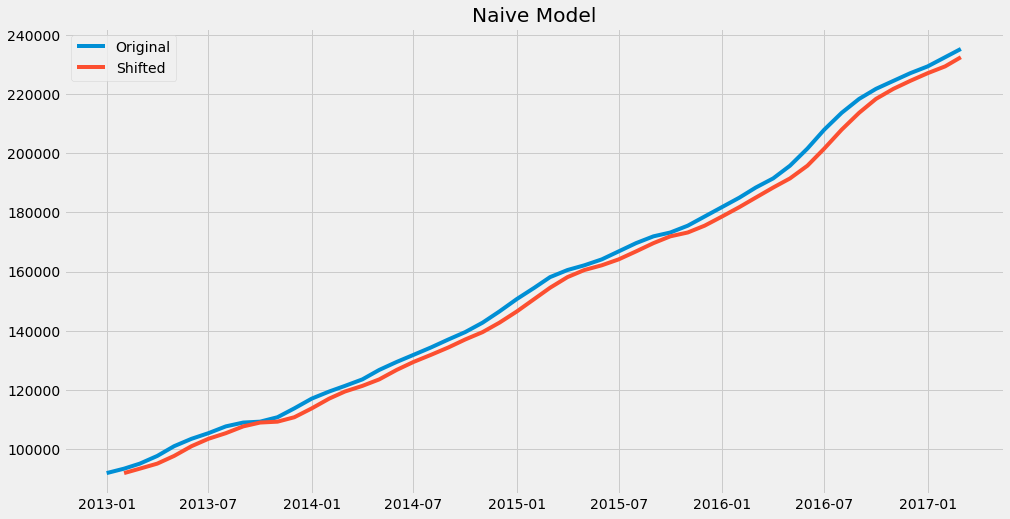

In [79]:
fig = plt.figure(figsize=(15,8))
plt.plot(train, label='Original')
plt.plot(naive, label='Shifted')
plt.legend(loc='best')
plt.title('Naive Model');

In [80]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

3085.02836291662

### ARIMA Modeling

In [151]:
def rmse(y_true, y_pred):
    sum_squared_diff = sum([(y2 - y1)**2 for y2,y1 in zip(y_true, y_pred)])
    rmse = (sum_squared_diff * (1/len(y_true))) ** 0.5
    return rmse

def cross_validate(model, df, split_freq='D', model_kwargs={}):
    '''
    model: uninitalized model- no parantheses 
    '''
   
    df = df.resample('M').mean()
   
    split = TimeSeriesSplit(n_splits=5)

    all_rmse = []
    for train_ind, val_ind in split.split(df):
        model_fit = model(df.iloc[train_ind, -1], **model_kwargs).fit()
        preds = model_fit.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
        true = df.iloc[val_ind, -1]
        all_rmse.append(rmse(true, preds))
    return all_rmse

#### Random Walk Model

In [145]:
random_walk_model = ARIMA(train, order=(0, 2, 0)).fit()
random_walk_model.aic

787.6931101319859

In [146]:
y_hat_random_walk_model = random_walk_model.predict(type='levels')
np.sqrt(mean_squared_error(train, y_hat_random_walk_model))

14940.077098479813

In [83]:
model_1 = ARIMA(train, order=(1, 2, 1)).fit()
model_1.aic

791.9777838635217

In [84]:
y_hat_model_1 = model_1.predict(type='levels')
np.sqrt(mean_squared_error(train, y_hat_model_1))

14878.576176452852

In [208]:
n_splits = 5
split = TimeSeriesSplit(n_splits=n_splits)
tot_RMSE = 0
train_with_ind = train.reset_index()
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2,2,2)).fit()
    preds = ar.predict(type='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    RMSE = np.sqrt(mean_squared_error(true, preds))
    print(RMSE)
    tot_RMSE += RMSE
print(f'Cross Validate Average RMSE: {tot_RMSE/n_splits}')

2570.0038249537142
1400.4705000557083
7135.539641530302
4493.684007851393
11735.459569226981
Cross Validate Average RMSE: 5467.03150872362


In [195]:
cross_validate(ARIMA, train, model_kwargs={'order':(3,2,2)})

[2457.681831257274,
 1402.6201117402709,
 8398.216650708728,
 7315.053195818548,
 13286.772714007433]

In [215]:
model_sarimax = SARIMAX(train, order=(0, 1, 0), seasonal_order=(2, 2, 0, 12),
                       enforce_stationarity=False, enforce_invertibility=False).fit()
model_sarimax.aic

-14.744897291277958

In [87]:
p = q = range(0,3)
d = range(1,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [88]:
count = 0
for param in pdq:
    for seasonal_param in seasonal_pdq:
        count += 1
        print(f'SARIMAX: {param} x {seasonal_param}')
print(f'{count} ITERATIONS')

SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 2, 12)
SARIMAX: (0, 1, 0) x (0, 2, 0, 12)
SARIMAX: (0, 1, 0) x (0, 2, 1, 12)
SARIMAX: (0, 1, 0) x (0, 2, 2, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 2, 12)
SARIMAX: (0, 1, 0) x (1, 2, 0, 12)
SARIMAX: (0, 1, 0) x (1, 2, 1, 12)
SARIMAX: (0, 1, 0) x (1, 2, 2, 12)
SARIMAX: (0, 1, 0) x (2, 1, 0, 12)
SARIMAX: (0, 1, 0) x (2, 1, 1, 12)
SARIMAX: (0, 1, 0) x (2, 1, 2, 12)
SARIMAX: (0, 1, 0) x (2, 2, 0, 12)
SARIMAX: (0, 1, 0) x (2, 2, 1, 12)
SARIMAX: (0, 1, 0) x (2, 2, 2, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 1) x (0, 2, 0, 12)
SARIMAX: (0, 1, 1) x (0, 2, 1, 12)
SARIMAX: (0, 1, 1) x (0, 2, 2, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 2, 12)
SARIMAX: (0, 1, 1) x (1, 2, 0, 12)
SARIMAX: (0, 1, 1) x

In [89]:
lowest_aic = 1000000
for param in pdq: 
    for seasonal_param in seasonal_pdq:
        try: 
            model = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                           enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print(f'SARIMAX {param} x {seasonal_param} - AIC:{results.aic}')
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            print('Oops!')
            continue
print(f'BEST RESULTS:  SARIMAX {best_param} x {best_seasonal_param} - AIC:{lowest_aic}')

SARIMAX (0, 1, 0) x (0, 1, 0, 12) - AIC:646.7896057425006
SARIMAX (0, 1, 0) x (0, 1, 1, 12) - AIC:1064.582758807875
SARIMAX (0, 1, 0) x (0, 1, 2, 12) - AIC:243.120863507752
SARIMAX (0, 1, 0) x (0, 2, 0, 12) - AIC:457.32888929618184
SARIMAX (0, 1, 0) x (0, 2, 1, 12) - AIC:237.2232439011708
SARIMAX (0, 1, 0) x (0, 2, 2, 12) - AIC:23.080429367600537
SARIMAX (0, 1, 0) x (1, 1, 0, 12) - AIC:459.5116335033508
SARIMAX (0, 1, 0) x (1, 1, 1, 12) - AIC:451.8660556316749
SARIMAX (0, 1, 0) x (1, 1, 2, 12) - AIC:240.69313042054335
SARIMAX (0, 1, 0) x (1, 2, 0, 12) - AIC:256.60408794175794
SARIMAX (0, 1, 0) x (1, 2, 1, 12) - AIC:235.83606900203
SARIMAX (0, 1, 0) x (1, 2, 2, 12) - AIC:9.151425758660606
SARIMAX (0, 1, 0) x (2, 1, 0, 12) - AIC:256.7847239617935
SARIMAX (0, 1, 0) x (2, 1, 1, 12) - AIC:460.76778419458395
SARIMAX (0, 1, 0) x (2, 1, 2, 12) - AIC:241.33126552513073
SARIMAX (0, 1, 0) x (2, 2, 0, 12) - AIC:-14.744897291277958
SARIMAX (0, 1, 0) x (2, 2, 1, 12) - AIC:-3.952874480573893
SARIMAX 

SARIMAX (1, 1, 2) x (0, 1, 1, 12) - AIC:990.2522521724833
SARIMAX (1, 1, 2) x (0, 1, 2, 12) - AIC:179.54479389978636
SARIMAX (1, 1, 2) x (0, 2, 0, 12) - AIC:391.3084801946056
SARIMAX (1, 1, 2) x (0, 2, 1, 12) - AIC:190.57686174202195
SARIMAX (1, 1, 2) x (0, 2, 2, 12) - AIC:12.0
SARIMAX (1, 1, 2) x (1, 1, 0, 12) - AIC:404.9261129033036
SARIMAX (1, 1, 2) x (1, 1, 1, 12) - AIC:372.5215285291357
SARIMAX (1, 1, 2) x (1, 1, 2, 12) - AIC:172.61747483394234
SARIMAX (1, 1, 2) x (1, 2, 0, 12) - AIC:221.3679629866976
SARIMAX (1, 1, 2) x (1, 2, 1, 12) - AIC:192.04082348190624
SARIMAX (1, 1, 2) x (1, 2, 2, 12) - AIC:14.0
SARIMAX (1, 1, 2) x (2, 1, 0, 12) - AIC:212.17388398985662
SARIMAX (1, 1, 2) x (2, 1, 1, 12) - AIC:215.97798250783197
SARIMAX (1, 1, 2) x (2, 1, 2, 12) - AIC:179.19221759499632
SARIMAX (1, 1, 2) x (2, 2, 0, 12) - AIC:27.768257295099474
SARIMAX (1, 1, 2) x (2, 2, 1, 12) - AIC:29.768461076075944
SARIMAX (1, 1, 2) x (2, 2, 2, 12) - AIC:16.0
SARIMAX (1, 2, 0) x (0, 1, 0, 12) - AIC:584.

SARIMAX (2, 2, 1) x (1, 1, 0, 12) - AIC:375.96724567056077
SARIMAX (2, 2, 1) x (1, 1, 1, 12) - AIC:377.25912524698646
SARIMAX (2, 2, 1) x (1, 1, 2, 12) - AIC:183.95437310482998
SARIMAX (2, 2, 1) x (1, 2, 0, 12) - AIC:184.68189592221876
SARIMAX (2, 2, 1) x (1, 2, 1, 12) - AIC:193.08371877130895
SARIMAX (2, 2, 1) x (1, 2, 2, 12) - AIC:14.0
SARIMAX (2, 2, 1) x (2, 1, 0, 12) - AIC:185.35223520565873
SARIMAX (2, 2, 1) x (2, 1, 1, 12) - AIC:185.24583119327835
SARIMAX (2, 2, 1) x (2, 1, 2, 12) - AIC:186.28233797643438
SARIMAX (2, 2, 1) x (2, 2, 0, 12) - AIC:12.0
SARIMAX (2, 2, 1) x (2, 2, 1, 12) - AIC:14.0
SARIMAX (2, 2, 1) x (2, 2, 2, 12) - AIC:16.0
SARIMAX (2, 2, 2) x (0, 1, 0, 12) - AIC:553.1603728173892
SARIMAX (2, 2, 2) x (0, 1, 1, 12) - AIC:1021.9026973307131
SARIMAX (2, 2, 2) x (0, 1, 2, 12) - AIC:167.45470908466456
SARIMAX (2, 2, 2) x (0, 2, 0, 12) - AIC:377.79396680058016
SARIMAX (2, 2, 2) x (0, 2, 1, 12) - AIC:166.97732248012412
SARIMAX (2, 2, 2) x (0, 2, 2, 12) - AIC:14.0
SARIMAX (

In [90]:
best_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(2, 2, 0, 12),
                    enforce_stationarity=False, enforce_invertibility=False).fit()
best_model.aic

-14.744897291277958

In [91]:
y_hat_best_model = best_model.predict(type='levels')
np.sqrt(mean_squared_error(train, y_hat_best_model))

19579.693412972352

In [159]:
cross_validate(SARIMAX, train, model_kwargs={'order':(0,1,0), 'seasonal_order':(2,2,1,12),
                                            'enforce_stationarity':False, 'enforce_invertibility':False})

[104749.42108745624,
 18914.972358356365,
 4612.618562161836,
 4768.516540812241,
 8989.85539372019]

In [216]:
preds_list = []
split = TimeSeriesSplit(n_splits=5)
tot_RMSE = 0
train_with_ind = train.reset_index()
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1], 
                    order=(0, 2, 0), 
                    seasonal_order=(1, 0, 0, 12),
                    enforce_stationarity=False, 
                    enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    preds_list.append(preds)
    RMSE = np.sqrt(mean_squared_error(true, preds))
    print(RMSE)
    tot_RMSE += RMSE
print(f'Cross Validate Average RMSE: {tot_RMSE/5}')
    

5906.352512337881
3756.131429078798
8601.564042543247
6968.996124580451
13748.511775950952
Cross Validate Average RMSE: 7796.311176898266


## AutoArima


In [227]:
out_of_sample_size = .2 * len(train)
auto_denver = pm.auto_arima(train, 
                            start_p=0,
                            start_q=0,
                            max_p=5,
                            max_q=5,
                            d=None,
                            seasonal=True,
                            start_P=0,
                            start_Q=0,
                            max_P=5,
                            max_Q=5,
                            m=12,
                            D=None,
                            test='kpss',
                            trace=True,
                            stepwise=False,
                            n_fits=1000)

 ARIMA(0,2,0)(0,0,0)[12]             : AIC=787.693, Time=0.01 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=789.416, Time=0.23 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=788.826, Time=0.13 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=790.798, Time=0.15 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=791.331, Time=0.29 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=793.323, Time=0.35 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=787.309, Time=0.06 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=789.002, Time=0.16 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=790.823, Time=0.17 sec
 ARIMA(0,2,0)(1,0,3)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,2,0)(1,0,4)[12]             : AIC=793.331, Time=0.31 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=788.842, Time=0.14 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=790.843, Time=0.47 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(2,0,3)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,2,0)(3,0,0)[1

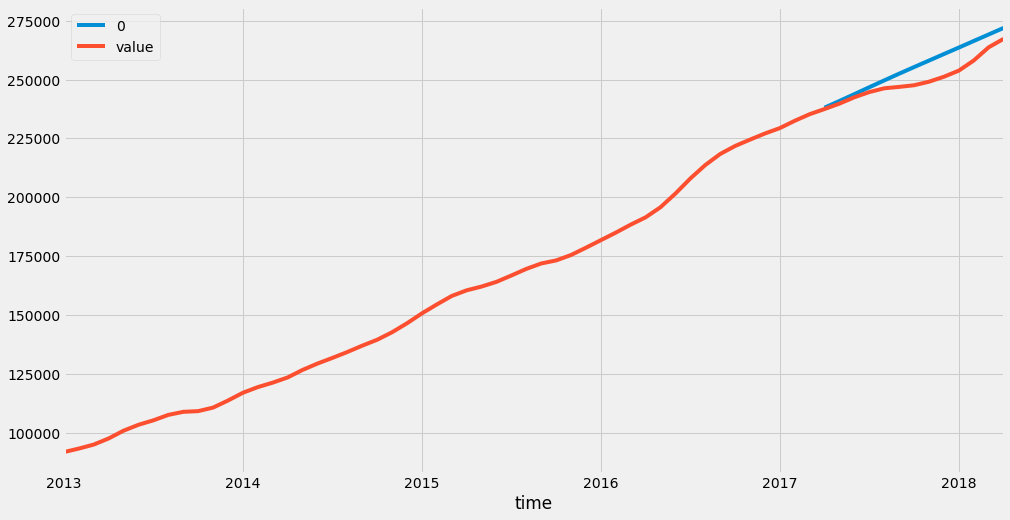

In [230]:
auto_denver_predicitons = pd.DataFrame(auto_denver.predict(n_periods=len(test), type='levels'), index=test.index)

fig, ax = plt.subplots(figsize=(15,8))
auto_denver_predicitons.plot(ax=ax, label='predicted')
denver_80216.plot(ax=ax, label='orginial');

## Prophet

In [251]:
train_proph = train.reset_index()
train_proph = train_proph.rename(columns={'value':'y', 'time':'ds'})

In [253]:
denver_prophet = proph(interval_width=.95)
denver_prophet.fit(train_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [260]:
y_hat_proph = denver_prophet.predict(train_proph)
np.sqrt(mean_squared_error(train_proph.y, y_hat_proph.yhat))

1119.5128263583977

In [265]:
future_dates = denver_prophet.make_future_dataframe(periods=36, freq='MS')
forecast = denver_prophet.predict(future_dates)

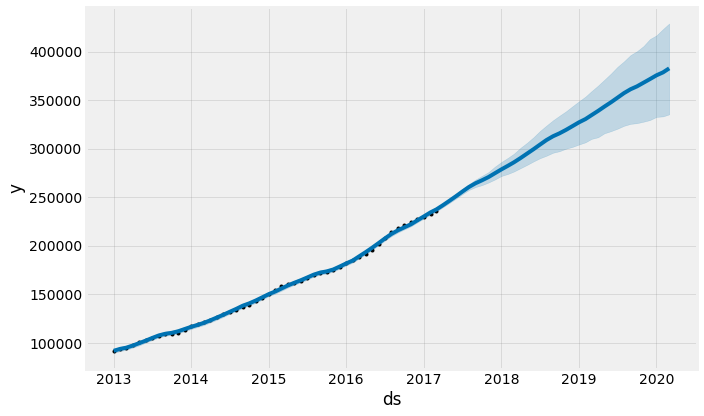

In [267]:
denver_prophet.plot(forecast, uncertainty=True);

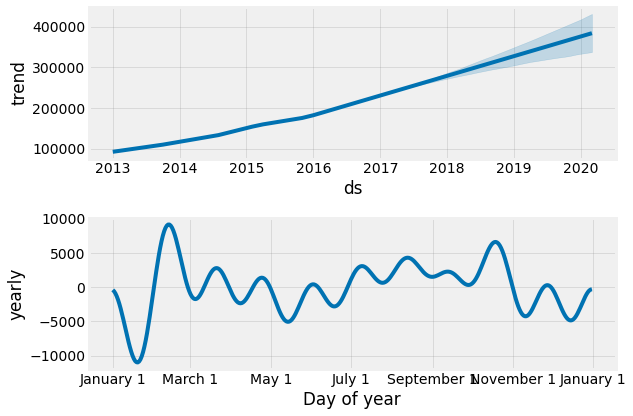

In [269]:
denver_prophet.plot_components(forecast);